# Montgomery County Collision Analysis

## Introduction
<br>We will be examining traffic collisions that occurred in Montgomery County, Maryland. Our data set has over fifteen thousand collision reports based on preliminary data. The data set includes columns such as the time of day that the crash occurred, the vehicle's impact locations, and the vehicle's movement at the time of the collision. We will be using this data to see what aspects of a crash lead to lower or higher rates of injury severity. Therefore, we are most interested in the correlation of 'Injury Severity', 'Vehicle Body Type', and 'Vehicle Movement' and others. We will create new columns based on factors that are most apparent to our exploration of the data.

In [6]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [64]:
df_county = pd.read_csv('data/Crash_Reporting_-_Drivers_Data.csv')
# df_state = pd.read_csv('data/Maryland_Statewide_Vehicle_Crashes.csv')
df_nonmotor = pd.read_csv('data/Crash_Reporting_-_Non-Motorists_Data.csv')

In [45]:
df_county.info()
# What was the correlation of weather data set combined with county data?

## Fill in na values w/r to timestamp of weather data set.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157554 entries, 0 to 157553
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   157554 non-null  object 
 1   Local Case Number               157554 non-null  object 
 2   Agency Name                     157554 non-null  object 
 3   ACRS Report Type                157554 non-null  object 
 4   Crash Date/Time                 157554 non-null  object 
 5   Route Type                      142110 non-null  object 
 6   Road Name                       142960 non-null  object 
 7   Cross-Street Type               142086 non-null  object 
 8   Cross-Street Name               142954 non-null  object 
 9   Off-Road Description            14592 non-null   object 
 10  Municipality                    17502 non-null   object 
 11  Related Non-Motorist            4958 non-null    object 
 12  Collision Type  

In [46]:
df_county['Route Type'].value_counts()

Maryland (State)        70708
County                  50730
Municipality             8623
US (State)               6860
Interstate (State)       2960
Other Public Roadway     1040
Government                610
Ramp                      520
Service Road               40
Unknown                    19
Name: Route Type, dtype: int64

In [47]:
df_state.head()

,YEAR,QUARTER,LIGHT_DESC,LIGHT_CODE,COUNTY_DESC,COUNTY_NO,MUNI_DESC,MUNI_CODE,JUNCTION_DESC,JUNCTION_CODE,...,FEET_MILES_FLAG_DESC,FEET_MILES_FLAG,DISTANCE_DIR_FLAG,REFERENCE_NO,REFERENCE_TYPE_CODE,REFERENCE_SUFFIX,REFERENCE_ROAD_NAME,LATITUDE,LONGITUDE,LOCATION
0,2020,Q2,Daylight,1.00,Baltimore,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.277263,-76.503693,POINT (-76.5036932 39.27726285)
1,2022,Q2,Dark Lights On,3.00,Montgomery,15.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.992210,-77.097021,POINT (-77.097020666667 38.9922095)
2,2020,Q4,NaN,6.02,Baltimore,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.323620,-76.503080,POINT (-76.503080116667 39.323620083333)
3,2022,Q1,Daylight,1.00,Baltimore,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.411213,-76.628028,POINT (-76.628028425147 39.411213105087)
4,2022,Q2,Dark Lights On,3.00,Queen Anne's,17.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.974880,-76.281090,POINT (-76.28109 38.97488)


In [48]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878343 entries, 0 to 878342
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   YEAR                   878343 non-null  int64  
 1   QUARTER                878343 non-null  object 
 2   LIGHT_DESC             841025 non-null  object 
 3   LIGHT_CODE             878343 non-null  float64
 4   COUNTY_DESC            878329 non-null  object 
 5   COUNTY_NO              878329 non-null  float64
 6   MUNI_DESC              0 non-null       float64
 7   MUNI_CODE              659957 non-null  float64
 8   JUNCTION_DESC          760119 non-null  object 
 9   JUNCTION_CODE          791512 non-null  float64
 10  COLLISION_TYPE_DESC    878343 non-null  object 
 11  COLLISION_TYPE_CODE    878343 non-null  int64  
 12  SURF_COND_DESC         789107 non-null  object 
 13  SURF_COND_CODE         791512 non-null  float64
 14  LANE_CODE              668083 non-nu

In [65]:
# Merge the two dataframes with the values that do not already exist in the county data
df_county = pd.merge(left=df_county, right=df_nonmotor[~df_nonmotor['Report Number'].isin(df_county['Report Number'])], on='Report Number', how='left')
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157554 entries, 0 to 157553
Data columns (total 74 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Report Number                     157554 non-null  object 
 1   Local Case Number_x               157554 non-null  object 
 2   Agency Name_x                     157554 non-null  object 
 3   ACRS Report Type_x                157554 non-null  object 
 4   Crash Date/Time_x                 157554 non-null  object 
 5   Route Type_x                      142110 non-null  object 
 6   Road Name_x                       142960 non-null  object 
 7   Cross-Street Type_x               142086 non-null  object 
 8   Cross-Street Name_x               142954 non-null  object 
 9   Off-Road Description_x            14592 non-null   object 
 10  Municipality_x                    17502 non-null   object 
 11  Related Non-Motorist_x            4958 non-null    o

## Data Cleaning
<br>
Let us now drop columns that are missing more than 10% of values on average

In [66]:
df_county.drop(columns=df_county.columns[df_county.isna().mean() >= .1], inplace=True)
df_county.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157554 entries, 0 to 157553
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Report Number                   157554 non-null  object 
 1   Local Case Number_x             157554 non-null  object 
 2   Agency Name_x                   157554 non-null  object 
 3   ACRS Report Type_x              157554 non-null  object 
 4   Crash Date/Time_x               157554 non-null  object 
 5   Route Type_x                    142110 non-null  object 
 6   Road Name_x                     142960 non-null  object 
 7   Cross-Street Type_x             142086 non-null  object 
 8   Cross-Street Name_x             142954 non-null  object 
 9   Collision Type_x                157028 non-null  object 
 10  Weather_x                       145184 non-null  object 
 11  Light_x                         156248 non-null  object 
 12  Person ID_x     

## Data Visualization

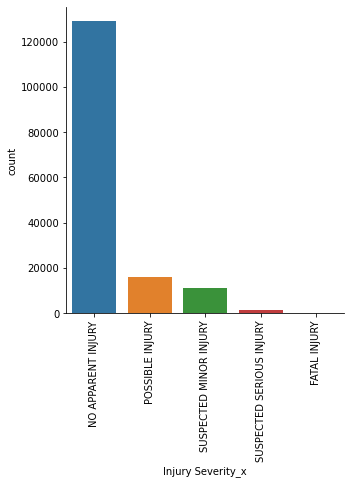

In [69]:
sns.catplot(x='Injury Severity_x', kind='count', data=df_county)
plt.xticks(rotation=90);

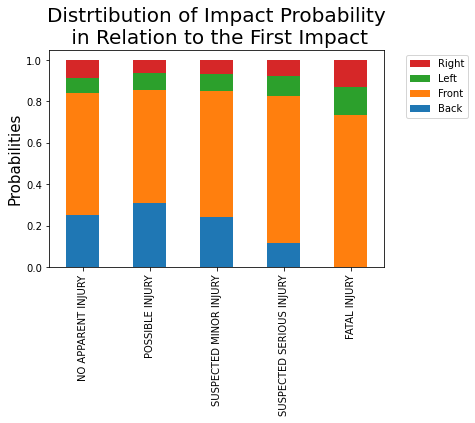

In [84]:
# Replace to simple impact locations
df_county['First Impact Simple'] = df_county['Vehicle First Impact Location'].replace({'ELEVEN OCLOCK': "Front", 'TWELVE OCLOCK': "Front", 'ONE OCLOCK': "Front", 'TWO OCLOCK': "Right", 'THREE OCLOCK': "Right", 'FOUR OCLOCK': "Right", 'FIVE OCLOCK': "Back", 'SIX OCLOCK': "Back", 'SEVEN OCLOCK': "Back", 'EIGHT OCLOCK': "Left", 'NINE OCLOCK': "Left", 'TEN OCLOCK': "Left", 'ROOF TOP': "Top", 'UNDERSIDE': "Bottom", 'NON-COLLISION': "No Collision",'UNKNOWK': "Unknown"})
# We will drop these values because they are unusual to compare with collisions 
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'UNKNOWN'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Top'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'Bottom'], inplace=True)
df_county.drop(df_county.index[df_county['First Impact Simple'] == 'No Collision'], inplace = True)
# Create cross tab chart 
movementImpact = pd.crosstab(df_county['Injury Severity_x'], df_county['First Impact Simple'])
movementImpact = movementImpact.div(df_county['Injury Severity_x'].value_counts(), axis=0)
# reorder from least to most severe
movementImpact.iloc[[1,2,3,4,0]].plot.bar(stacked=True)
plt.title('Distrtibution of Impact Probability\n in Relation to the First Impact', size=20)
plt.xticks(rotation = 90)
plt.ylabel('Probabilities', size=15)
current_handles, curr_labels = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)
reverse_labels = reversed(curr_labels)
plt.legend(reversed_handles, reverse_labels, bbox_to_anchor=(1.05, 1.0), loc='upper left');

## Conclusion